In [42]:
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread("../_static/demo_thumbnails/regular_demo_thumbnails/thumbnail_shadow_hamiltonian_simulation.png")[:, :, 0]

U, Lambda, Vd = np.linalg.svd(img)

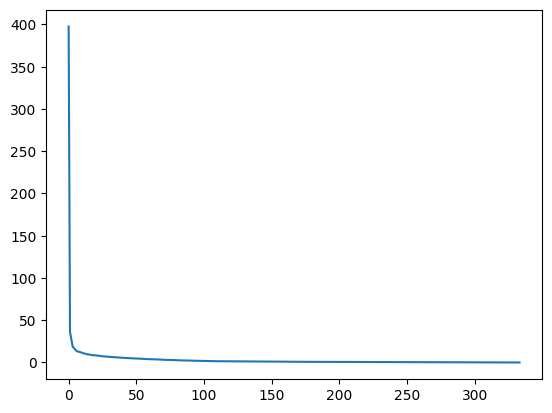

In [43]:
plt.plot(Lambda)

Text(0.5, 1.0, 'compressed image')

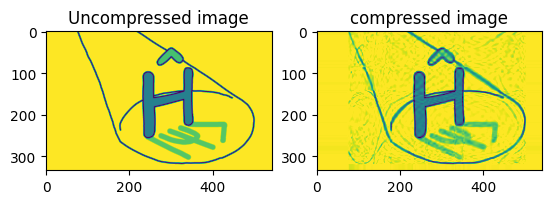

In [46]:


chi = 30
U = U[:, :chi]
Lambda = Lambda[:chi]
# Lambda = Lambda/np.linalg.norm(Lambda)
Vd = Vd[:chi]

compressed_img = U @ np.diag(Lambda) @ Vd

fig, axs = plt.subplots(ncols=2)
ax = axs[0]
ax.imshow(img, vmin=0, vmax=1)
ax.set_title("Uncompressed image")

ax = axs[1]
ax.imshow(compressed_img, vmin=0, vmax=1)
ax.set_title("compressed image")


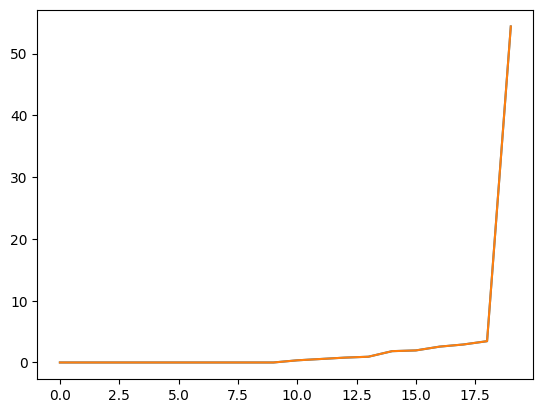

In [54]:
M = np.random.rand(10, 20)
M = M.conj().T @ M
assert np.allclose(M, M.conj().T)

U, S, Vd = np.linalg.svd(M)
eigvals = np.linalg.eigvalsh(M)

plt.plot(np.sort(S))
plt.plot(np.sort(eigvals))

In [35]:
size_original = np.prod(img.shape)
size_compressed = np.prod(U.shape) + np.prod(Lambda.shape) + np.prod(Vd.shape)

print(f"original image: {size_original}, compressed image: {size_compressed}, factor {size_original/size_compressed:.3f} saving")

original image: 181028, compressed image: 43850, factor 4.128 saving


In [93]:
n = 3 # three sites = three legs
psi = np.random.rand(2**3)
psi = psi / np.linalg.norm(psi)  # random, normalized state vector
psi = np.reshape(psi, (2, 2, 2)) # rewrite psi as rank-n tensor

# reshape vector to matrix
psi = np.reshape(psi, (2, 2**(n-1)))
# SVD to split off first site
U, Lambda, Vd = np.linalg.svd(psi, full_matrices=False)

Us = []
U = np.reshape(U, (1, 2, 2)) # mu1, s2, mu2
Us.append(U)

In [94]:
psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
psi_remainder = np.reshape(psi_remainder, (2*2, 2))  # (mu1 s2), s3
U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

U = np.reshape(U, (2, 2, 2)) # mu1, s2, mu2
Us.append(U)

U.shape, Lambda.shape, Vd.shape

((2, 2, 2), (2,), (2, 2))

In [95]:
psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
psi_remainder = np.reshape(psi_remainder, (2*2, 1))  # (mu1 s2), s3
U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

U.shape, Lambda.shape, Vd.shape

U = np.reshape(U, (2, 2, 1)) # mu1, s2, mu2
Us.append(U)

In [135]:
print(f"Shapes of Us: {[_.shape for _ in Us]}")

psi_reconstruct = Us[0]

for i in range(1, len(Us)):
    psi_reconstruct = np.tensordot(psi_reconstruct, Us[i], 1) # contract the rightmost with the left most index

print(f"Shape of reconstructed psi: {[_.shape for _ in Us]}")
# remove dummy dimensions
psi_reconstruct = np.reshape(psi_reconstruct, (2, 2, 2))
# original shape of original psi
psi = np.reshape(psi, (2, 2, 2))

np.allclose(psi, psi_reconstruct)

Shapes of Us: [(1, 2, 2), (2, 2, 2), (2, 2, 1)]
Shape of reconstructed psi: [(1, 2, 2), (2, 2, 2), (2, 2, 1)]


True

In [137]:

def split(M, bond_dim):
    """Split a matrix M via SVD and keep only the ``bond_dim`` largest entries"""
    U, S, Vd = np.linalg.svd(M, full_matrices=False)
    bonds = len(S)
    Vd = Vd.reshape(bonds, 2, -1)
    U = U.reshape((-1, 2, bonds))
    
    # keep only chi bonds
    chi = np.min([bonds, bond_dim])
    U, S, Vd = U[:, :, :chi], S[:chi], Vd[:chi]
    return U, S, Vd

def dense_to_mps(psi, bond_dim):
    """Turn a state vector ``psi`` into an MPS with bond dimension ``bond_dim``"""
    Ms = []
    Ss = []

    psi = np.reshape(psi, (2, -1))   # split psi[2, 2, 2, 2..] = psi[2, (2x2x2...)]
    U, S, Vd = split(psi, bond_dim)  # psi[2, (2x2x..)] = U[2, mu] S[mu] Vd[mu, (2x2x2x..)]

    Ms.append(U)
    Ss.append(Ss)
    bondL = Vd.shape[0]
    psi = Vd

    for _ in range(n-2):
        psi = np.reshape(psi, (2*bondL, -1))   # reshape psi[2 * bondL, (2x2x2...)]
        U, S, Vd = split(psi, bond_dim)        # psi[2, (2x2x..)] = U[2, mu] S[mu] Vd[mu, (2x2x2x..)]
        Ms.append(U)
        Ss.append(Ss)

        psi = Vd
        bondL = Vd.shape[0]

    Ms.append(Vd)
    
    return Ms, Ss

In [140]:
n = 12
bond_dim = 10000

psi = np.random.rand(*[2]*n)
psi = psi/np.linalg.norm(psi)
Ms, Ss = dense_to_mps(psi, bond_dim)

[M.shape for M in Ms]

[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 8),
 (8, 2, 16),
 (16, 2, 32),
 (32, 2, 64),
 (64, 2, 32),
 (32, 2, 16),
 (16, 2, 8),
 (8, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [141]:
Ms, Ss = dense_to_mps(psi, 5)

[M.shape for M in Ms]

[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [91]:
Lambda, Vd

(array([1.93324382]), array([[1.]]))

In [92]:
np.linalg.norm(psi)

1.9332438180339973

In [79]:
psi_remainder.shape

(2, 2)